<a href="https://colab.research.google.com/github/ZonaQuant/Notebooks/blob/main/EJEMPLO_K_MEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EJEMPLO K-MEANS

Ejemplo simple del uso de K-means para la detección del régimen de mercado.

### 1. IMPORTACIÓN DE LIBRERÍAS 

In [ ]:
!pip install yfinance 
import yfinance as yf
!pip install talib-binary
import talib as tl
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2. FUNCIÓN PARA OBTENER HISTÓRICOS DE YAHOO FINANCE

In [ ]:
def historico(ticker, days):
    today = datetime.today()
    initial = today - dt.timedelta(days=days)
    today = today.strftime('%Y-%m-%d')
    initial = initial.strftime('%Y-%m-%d')
    data = yf.download(ticker, start=initial, end=today, progress=False)
    return data

### 3. FUNCIÓN PARA CALCULAR INDICADORES CON DIFERENTES PERIODOS

In [ ]:
def indicators(data):
    high = np.array(data["high"])
    low = np.array(data["low"])
    close = np.array(data["close"])
    ta = []
    columns = []   
    periods = list(range(5,50))

    # CCI - Commodity Channel Index
    for n in periods:
        name = "CCI" + str(n)
        ta.append(pd.Series(tl.CCI(high, low, close, timeperiod=n)))
        columns.append(name)
    # RSI - Relative Strength Index
    for n in periods:
        name = "RSI" + str(n)
        ta.append(pd.Series(tl.RSI(close, timeperiod=n)))
        columns.append(name)    
    # STOCH - Stochastic
    for n in periods:
        name_k = "STOCHK" + str(n)
        name_d = "STOCHD" + str(n)
        fastk, fastd = tl.STOCHF(high, low, close, fastk_period=n, fastd_period=3, fastd_matype=0)
        ta.append(pd.Series(fastk))        
        columns.append(name_k)   
        ta.append(pd.Series(fastd))        
        columns.append(name_d)   
    # WILLR - Williams' %R
    for n in periods:
        name = "WILLR" + str(n)
        ta.append(pd.Series(tl.WILLR(high, low, close, timeperiod=n)))
        columns.append(name)
    # ADX
    for n in [5,10,15,20,25]:
        name = "ADX" + str(n)
        ta.append(pd.Series(tl.ADX(high, low, close, timeperiod=n)))
        columns.append(name)
    # MACD - Moving Average Convergence/Divergence
    for n in periods:
        name = "MACD" + str(n)
        macd, macdsignal, macdhist = tl.MACD(close, fastperiod=int(n/2), slowperiod=n, signalperiod=9)
        ta.append(pd.Series(macd))
        columns.append(name)      
    # MINUS_DI - Minus Directional Indicator
    for n in periods:
        name = "DI" + str(n)
        ta.append(pd.Series(tl.MINUS_DI(high, low, close, timeperiod=n)))
        columns.append(name)     
    # MOM - Momentum
    for n in periods:
        name = "MOM" + str(n)
        ta.append(pd.Series(tl.MOM(close, timeperiod=n)))
        columns.append(name)      
    # PLUS_DI - Plus Directional Indicator
    for n in periods:
        name = "PDI" + str(n)
        ta.append(pd.Series(tl.PLUS_DI(high, low, close, timeperiod=n)))
        columns.append(name)      

    df = pd.concat(ta, axis=1)
    df.columns = columns
    return df

### 4. FUNCIÓN PARA GENERAR CLÚSTERS

In [ ]:
def clusters(ticker, days):
    datos = historico(ticker, days)
    datos.columns = ["open", "high", "low", "close", "adj close", "volume"]

    features = indicators(datos)
    features.index = datos.index
    features["close"] = datos["close"]
    features = features.dropna()
    X = features.iloc[:,:-1]
    Y = features.iloc[:,-1]
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    
    kmeans = KMeans(n_clusters=2).fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    df = pd.DataFrame()
    df.index = features.index
    df["labels"] = labels
    df["close"] = Y

    return df

### 5. FUNCIÓN PARA GENERAR EL DATASET CON INDICADORES Y CLÚSTERS

In [ ]:
def dataset(ticker, days):
    df = clusters(ticker, days)
 
    datos = historico(ticker, days)
    datos.columns = ["open", "high", "low", "close", "adj close", "volume"]

    features = indicators(datos)
    features.index = datos.index
    features["close"] = datos["close"]
    features = features.iloc[(len(features)-len(df)):,:]

    dataset = features
    dataset["label"] = df["labels"].shift(-4)
    dataset = dataset.dropna()

    return dataset

### 6. EJEMPLO GRÁFICO PARA EL NASDAQ

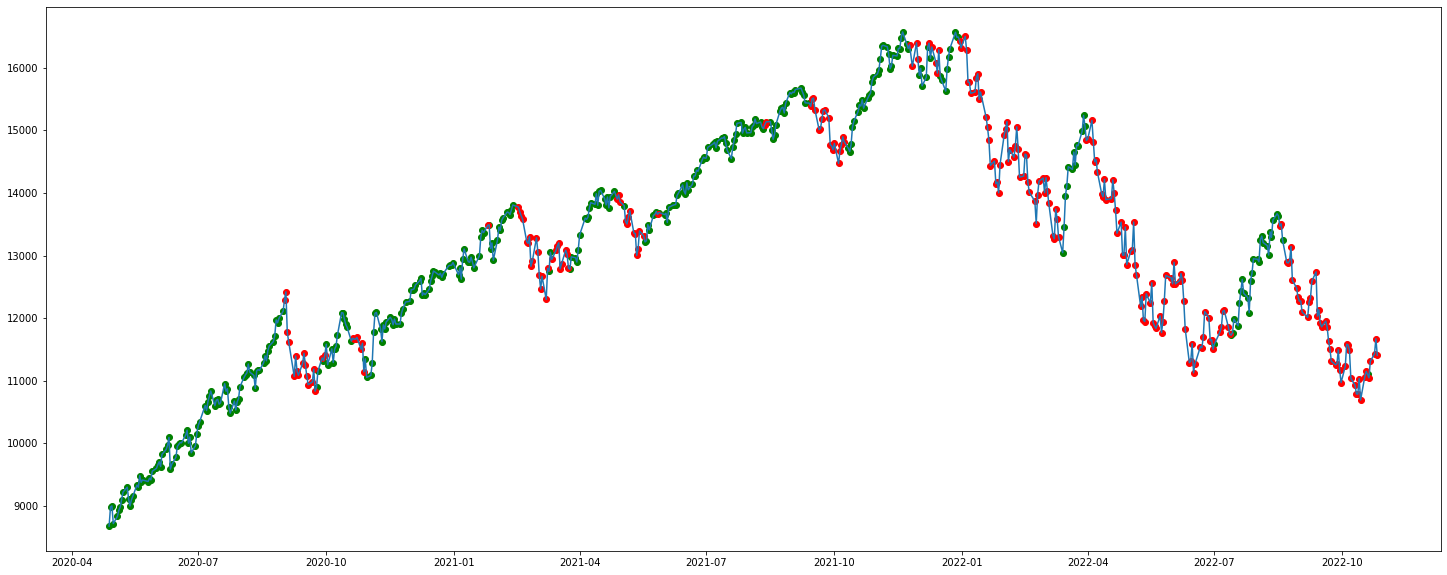

In [ ]:
df_dataset = dataset("^NDX", 1000)

zero = df_dataset[df_dataset["label"]==0]
one = df_dataset[df_dataset["label"]==1]

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.scatter(zero.index, zero["close"], c = "green")
ax.scatter(one.index, one["close"], c = "red")
ax.plot(df_dataset.index, df_dataset["close"])
plt.show()

### 7. EJEMPLO GRÁFICO PARA EL EURUSD

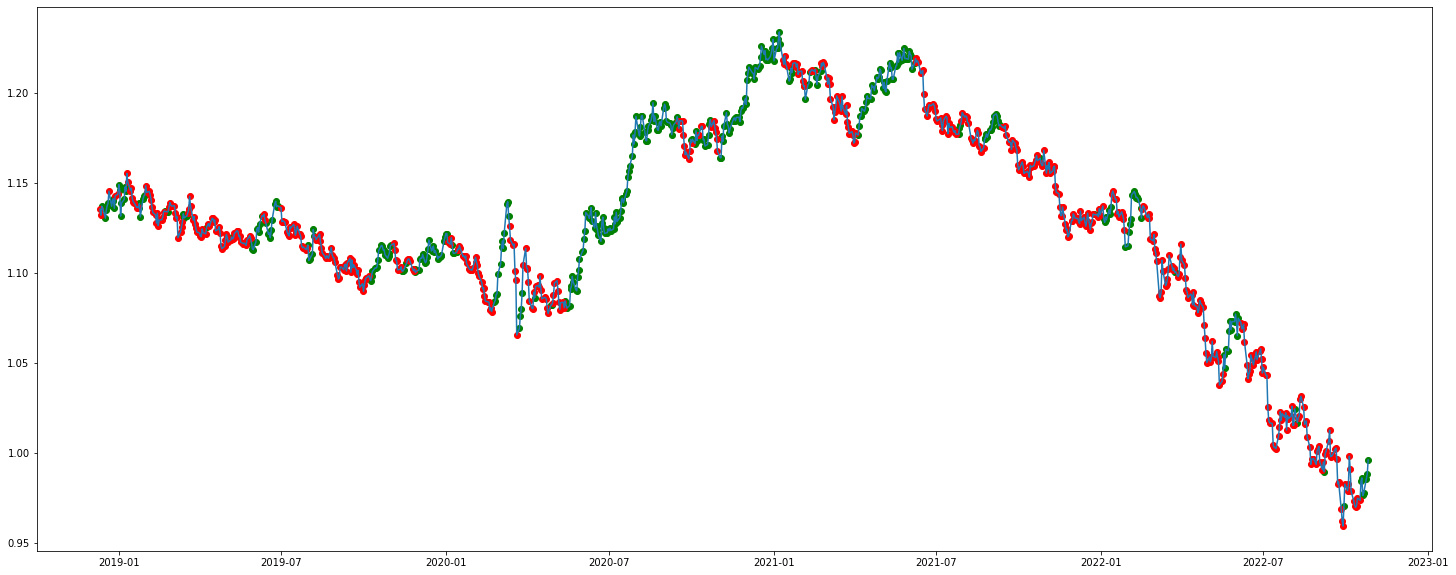

In [ ]:
df_dataset = dataset("EURUSD=X", 1500)

zero = df_dataset[df_dataset["label"]==0]
one = df_dataset[df_dataset["label"]==1]

fig, ax = plt.subplots(1,1, figsize=(25,10))
ax.scatter(zero.index, zero["close"], c = "green")
ax.scatter(one.index, one["close"], c = "red")
ax.plot(df_dataset.index, df_dataset["close"])
plt.show()

### COMENTARIOS

El uso de la función shift en la columna "label" hace que miremos al futuro, lo cual inhabilita el uso de esto tal cual.

Ahora bien, los ejemplos gráficos muestran que este simple uso de K-means es útil para etiquetar subidas y bajadas de un activo.

A partir de ese etiquetado se puede aplicar cualquier modelo de machine learning para resolver un problema simple de clasificación.